In [55]:
import os
import math
import pickle
import random
from dataclasses import dataclass
from typing import List, Tuple, Optional, Dict
import tqdm

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

# PyTorch Geometric containers only (no torch_scatter required)
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.model_selection import KFold, train_test_split

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import RDConfig
from rdkit.Chem import ChemicalFeatures

In [67]:
cep_path = "/Users/williamsilver/Ai in materials workshop/AI-in-materials-workshop/AI-in-materials-workshop/41597_2016_BFsdata201686_MOESM94_ESM.csv"

cep = pd.read_csv(cep_path)

# If confnum exists, drop it (WITHOUT inplace so cep isn't None)
if "confnum" in cep.columns:
    cep = cep.drop(columns=["confnum"])

In [90]:
# Small, fixed vocab for atomic numbers to keep feature dims modest. 
COMMON_ATOMIC_NUMS = [1, 5, 6, 7, 8, 9, 14, 15, 16, 17, 35, 53] #H B C N O F Si P S Cl Br I 
ATOMNUM_TO_IDX = {z: i for i, z in enumerate(COMMON_ATOMIC_NUMS)} 
ATOM_FDIM = len(COMMON_ATOMIC_NUMS) + 6
# one-hot + 6 numeric/binary
BOND_TYPES = [ Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC, ] 
BOND_TO_IDX = {bt: i for i, bt in enumerate(BOND_TYPES)} 
BOND_FDIM = len(BOND_TYPES) + 2 # one-hot + (conjugated, in_ring)


def atom_features(atom: Chem.rdchem.Atom) -> List[float]: 
    z = atom.GetAtomicNum() 
    onehot = [0.0] * len(COMMON_ATOMIC_NUMS) 
    if z in ATOMNUM_TO_IDX: onehot[ATOMNUM_TO_IDX[z]] = 1.0 
    degree = float(atom.GetDegree()) 
    formal_charge = float(atom.GetFormalCharge()) 
    aromatic = 1.0 if atom.GetIsAromatic() else 0.0 
    total_h = float(atom.GetTotalNumHs()) 
    hybrid = atom.GetHybridization() 
    hyb_map = { Chem.rdchem.HybridizationType.SP: 1.0, Chem.rdchem.HybridizationType.SP2: 2.0, Chem.rdchem.HybridizationType.SP3: 3.0, } 
    hyb_val = hyb_map.get(hybrid, 0.0) 
    in_ring = 1.0 if atom.IsInRing() else 0.0 
    return onehot + [degree, formal_charge, aromatic, total_h, hyb_val, in_ring] 

def bond_features(bond: Chem.rdchem.Bond) -> List[float]: 
    bt = bond.GetBondType() 
    onehot = [0.0] * len(BOND_TYPES) 
    if bt in BOND_TO_IDX: onehot[BOND_TO_IDX[bt]] = 1.0 
    conjugated = 1.0 if bond.GetIsConjugated() else 0.0 
    in_ring = 1.0 if bond.IsInRing() else 0.0 
    return onehot + [conjugated, in_ring] 

def smiles_to_data(smiles: str, y: np.ndarray) -> Optional[Data]: 
    mol = Chem.MolFromSmiles(smiles) 
    if mol is None: return None 
    x = torch.tensor([atom_features(a) for a in mol.GetAtoms()], dtype=torch.float32) 
    edge_index = [] 
    edge_attr = [] 
    for b in mol.GetBonds(): 
        i = b.GetBeginAtomIdx() 
        j = b.GetEndAtomIdx() 
        bf = bond_features(b) 
        edge_index.append([i, j]) 
        edge_index.append([j, i]) 
        edge_attr.append(bf) 
        edge_attr.append(bf) 
    if len(edge_index) == 0: 
        edge_index = torch.empty((2, 0), dtype=torch.long) 
        edge_attr = torch.empty((0, BOND_FDIM), dtype=torch.float32) 
    else: 
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous() 
        edge_attr = torch.tensor(edge_attr, dtype=torch.float32) 
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=torch.tensor(y, dtype=torch.float32)) 

In [101]:
@dataclass
class CFG:
    smiles_col: str = "smiles"
    target_cols: Tuple[str, ...] = ("homo", "lumo", "gap")
    seed: int = 42

    # Model size
    hidden_dim: int = 128
    msg_dim: int = 128
    num_layers: int = 4
    dropout: float = 0.10

    # Training
    batch_size: int = 128
    lr: float = 2e-3
    weight_decay: float = 1e-4
    max_epochs: int = 80
    patience: int = 10
    grad_clip: float = 2.0

    # Speed knobs
    limit_rows: Optional[int] = None
    num_workers: int = 0

cfg = CFG()

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(cfg.seed)

# optional quick test
if cfg.limit_rows is not None:
    cep_work = cep.sample(cfg.limit_rows, random_state=cfg.seed).reset_index(drop=True)
else:
    cep_work = cep.copy()

cep_work = cep_work.dropna(subset=[cfg.smiles_col, *cfg.target_cols]).reset_index(drop=True)



In [102]:
# ---------------- Precompute ALL graphs once ----------------
def precompute_graphs_all(cep_df, cfg: CFG, out_path: str):
    data_list = []
    bad = 0

    for i in range(len(cep_df)):
        row = cep_df.iloc[i]
        smiles = row[cfg.smiles_col]
        targets = row[list(cfg.target_cols)].to_numpy(np.float32)

        # store RAW targets in data.y (no standardisation here)
        data = smiles_to_data(smiles, y=targets)
        if data is None:
            bad += 1
            data_list.append(None)  # keep alignment by index
            continue
        data_list.append(data)

    torch.save(data_list, out_path)
    print(f"Saved list length={len(data_list)} -> {out_path}. Invalid smiles={bad}.")

ALL_GRAPHS_PATH = "cep_graphs_all.pt"
precompute_graphs_all(cep_work, cfg, ALL_GRAPHS_PATH)

Saved list length=316 -> cep_graphs_all.pt. Invalid smiles=0.


In [103]:
class IndexedGraphDataset(Dataset):
    """
    Loads a list of Data objects (or None) and exposes only specified indices.
    """
    def __init__(self, all_graphs_path: str, indices: np.ndarray):
        self.data_list = torch.load(all_graphs_path)
        self.indices = np.asarray(indices)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        data = self.data_list[int(self.indices[i])]
        if data is None:
            # defensive: should be filtered out by valid_mask below
            raise ValueError("Encountered None graph; filter indices with valid_mask first.")
        return data

def valid_mask_from_saved_list(all_graphs_path: str) -> np.ndarray:
    lst = torch.load(all_graphs_path)
    return np.array([d is not None for d in lst], dtype=bool)

valid_mask = valid_mask_from_saved_list(ALL_GRAPHS_PATH)
all_idx = np.arange(len(valid_mask))
valid_idx = all_idx[valid_mask]  # only these rows are usable

In [104]:
def index_add_pool(x: torch.Tensor, batch: torch.Tensor) -> torch.Tensor:
    B = int(batch.max().item()) + 1 if batch.numel() > 0 else 1
    out = torch.zeros((B, x.size(-1)), device=x.device, dtype=x.dtype)
    out.index_add_(0, batch, x)
    return out

class MLP(nn.Module):
    def __init__(self, in_dim: int, hidden_dim: int, out_dim: int, dropout: float):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, out_dim),
        )
    def forward(self, x): return self.net(x)

class FastMessageLayer(nn.Module):
    """
    Node update only.
    Messages use [x_j || edge_attr] but edge_attr stays fixed.
    """
    def __init__(self, hidden_dim: int, msg_dim: int, dropout: float, use_bn: bool = False):
        super().__init__()
        self.msg = nn.Sequential(
            nn.Linear(hidden_dim + hidden_dim, msg_dim),
            nn.ReLU(),
            nn.Linear(msg_dim, hidden_dim),
        )
        self.self_lin = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = dropout
        self.use_bn = use_bn
        self.bn = nn.BatchNorm1d(hidden_dim) if use_bn else None

    def forward(self, x, edge_index, edge_attr):
        if edge_index.numel() == 0:
            x2 = self.self_lin(x)
            if self.use_bn: x2 = self.bn(x2)
            return F.relu(x2), edge_attr

        src, dst = edge_index[0], edge_index[1]

        m_in = torch.cat([x[src], edge_attr], dim=-1)  # [E, 2H]
        m = self.msg(m_in)                             # [E, H]

        agg = torch.zeros_like(x)
        agg.index_add_(0, dst, m)

        x_up = agg + self.self_lin(x)
        if self.use_bn:
            x_up = self.bn(x_up)
        x_up = F.relu(x_up)
        x_up = F.dropout(x_up, p=self.dropout, training=self.training)
        return x_up, edge_attr

class DualMPNN(nn.Module):
    def __init__(self, node_in: int, edge_in: int, hidden_dim: int, msg_dim: int, num_layers: int, dropout: float, out_dim: int):
        super().__init__()
        self.node_emb = nn.Linear(node_in, hidden_dim)
        self.edge_emb = nn.Linear(edge_in, hidden_dim)

        self.layers = nn.ModuleList([
            FastMessageLayer(hidden_dim, msg_dim, dropout, use_bn=False)
            for _ in range(num_layers)
        ])

        self.readout_mlp = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, out_dim),
        )

    def forward(self, data: Data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        x = F.relu(self.node_emb(x))

        if edge_attr.numel() > 0:
            edge_attr = F.relu(self.edge_emb(edge_attr))

        for layer in self.layers:
            x, edge_attr = layer(x, edge_index, edge_attr)

        g_sum = index_add_pool(x, batch)
        counts = torch.bincount(batch, minlength=g_sum.size(0)).clamp_min(1).unsqueeze(-1).to(x.device)
        g_mean = g_sum / counts

        g = torch.cat([g_sum, g_mean], dim=-1)
        return self.readout_mlp(g)


In [105]:
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import r2_score, mean_squared_error
def standardise(y_raw: torch.Tensor, mean: torch.Tensor, std: torch.Tensor):
    return (y_raw - mean) / (std + 1e-8)

@torch.no_grad()
def evaluate_std(model, loader, device, mean_t, std_t):
    model.eval()
    losses = []
    for batch in loader:
        batch = batch.to(device)
        out = model(batch)

        y_raw = batch.y.view(out.shape)
        y = standardise(y_raw, mean_t, std_t)

        loss = F.smooth_l1_loss(out, y)
        losses.append(loss.item())
    return float(np.mean(losses))


def train_from_loaders_cv(cfg: CFG, train_loader, val_loader, mean_np, std_np):
    device = torch.device("cpu")
    mean_t = torch.tensor(mean_np, dtype=torch.float32, device=device)
    std_t  = torch.tensor(std_np,  dtype=torch.float32, device=device)

    model = DualMPNN(
        node_in=ATOM_FDIM,
        edge_in=BOND_FDIM,
        hidden_dim=cfg.hidden_dim,
        msg_dim=cfg.msg_dim,
        num_layers=cfg.num_layers,
        dropout=cfg.dropout,
        out_dim=len(cfg.target_cols),
    ).to(device)

    opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

    best_val = float("inf")
    best_state = None
    bad_epochs = 0

    for epoch in range(1, cfg.max_epochs + 1):
        model.train()
        train_losses = []

        for batch in train_loader:
            batch = batch.to(device)
            opt.zero_grad(set_to_none=True)

            out = model(batch)
            y_raw = batch.y.view(out.shape)
            y = standardise(y_raw, mean_t, std_t)

            loss = F.smooth_l1_loss(out, y)
            loss.backward()

            if cfg.grad_clip is not None:
                nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip)

            opt.step()
            train_losses.append(loss.item())

        tr_loss = float(np.mean(train_losses))
        val_loss = evaluate_std(model, val_loader, device, mean_t, std_t)
        print(f"Epoch {epoch:03d} | train {tr_loss:.4f} | val {val_loss:.4f}")

        if val_loss < best_val - 1e-4:
            best_val = val_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad_epochs = 0
        else:
            bad_epochs += 1
            if bad_epochs >= cfg.patience:
                print("Early stopping.")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    return model



In [106]:
@torch.no_grad()
def predict_raw_units(model, loader, device, mean_np, std_np):
    """
    Model outputs standardised targets. Convert to raw units here.
    Also return raw y_true from batch.y.
    """
    model.eval()
    mean_t = torch.tensor(mean_np, dtype=torch.float32)
    std_t  = torch.tensor(std_np,  dtype=torch.float32)

    preds_raw = []
    trues_raw = []

    for batch in loader:
        batch = batch.to(device)
        out_std = model(batch).detach().cpu()                 # (B,3) standardised
        y_raw   = batch.y.view(out_std.shape).detach().cpu()  # (B,3) raw

        pred_raw = out_std * (std_t + 1e-8) + mean_t
        preds_raw.append(pred_raw)
        trues_raw.append(y_raw)

    return torch.cat(preds_raw, 0).numpy(), torch.cat(trues_raw, 0).numpy()



===== FOLD 1/5 =====
Epoch 001 | train 1.2164 | val 0.5188
Epoch 002 | train 0.5378 | val 0.3963
Epoch 003 | train 0.4388 | val 0.2863
Epoch 004 | train 0.3710 | val 0.3219
Epoch 005 | train 0.3722 | val 0.2999
Epoch 006 | train 0.3535 | val 0.2842
Epoch 007 | train 0.3419 | val 0.2889
Epoch 008 | train 0.3551 | val 0.2838
Epoch 009 | train 0.3267 | val 0.2835
Epoch 010 | train 0.3302 | val 0.2815
Epoch 011 | train 0.3446 | val 0.2814
Epoch 012 | train 0.3468 | val 0.2800
Epoch 013 | train 0.3341 | val 0.2764
Epoch 014 | train 0.3263 | val 0.2748
Epoch 015 | train 0.3381 | val 0.2758
Epoch 016 | train 0.3326 | val 0.2712
Epoch 017 | train 0.3172 | val 0.2664
Epoch 018 | train 0.3188 | val 0.2659
Epoch 019 | train 0.3176 | val 0.2583
Epoch 020 | train 0.3153 | val 0.2548
Epoch 021 | train 0.3124 | val 0.2457
Epoch 022 | train 0.3036 | val 0.2447
Epoch 023 | train 0.2991 | val 0.2317
Epoch 024 | train 0.3116 | val 0.2249
Epoch 025 | train 0.2944 | val 0.2323
Epoch 026 | train 0.2983 | v

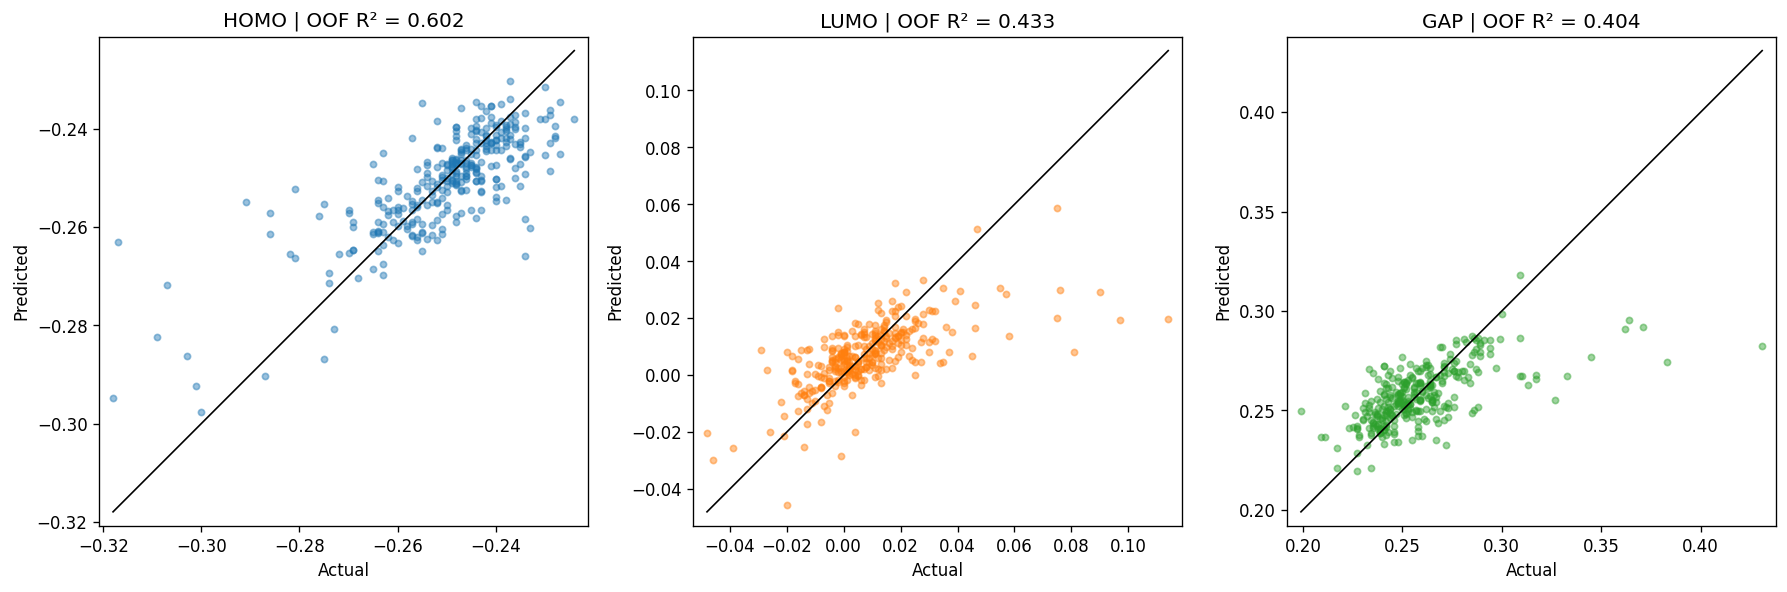

In [107]:
import matplotlib.pyplot as plt

def run_5fold_oof(cep_df, cfg: CFG, all_graphs_path: str, valid_idx: np.ndarray):
    kf = KFold(n_splits=5, shuffle=True, random_state=cfg.seed)

    N = len(cep_df)
    oof_pred = np.full((N, len(cfg.target_cols)), np.nan, dtype=np.float32)
    oof_true = np.full((N, len(cfg.target_cols)), np.nan, dtype=np.float32)

    # We only split over valid_idx, but we store back into full-length arrays
    for fold, (tr_pos, te_pos) in enumerate(kf.split(valid_idx), start=1):
        tr_idx = valid_idx[tr_pos]
        te_idx = valid_idx[te_pos]

        # inner val split for early stopping
        tr_sub, va_sub = train_test_split(
            tr_idx, test_size=0.15, random_state=cfg.seed, shuffle=True
        )

        # fold mean/std from TRAIN ONLY (no leakage)
        y_train = cep_df.iloc[tr_sub][list(cfg.target_cols)].to_numpy(np.float32)
        mean = y_train.mean(axis=0)
        std  = y_train.std(axis=0) + 1e-6

        train_ds = IndexedGraphDataset(all_graphs_path, tr_sub)
        val_ds   = IndexedGraphDataset(all_graphs_path, va_sub)
        test_ds  = IndexedGraphDataset(all_graphs_path, te_idx)

        train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True,  num_workers=cfg.num_workers)
        val_loader   = DataLoader(val_ds,   batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)
        test_loader  = DataLoader(test_ds,  batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)

        print(f"\n===== FOLD {fold}/5 =====")
        model = train_from_loaders_cv(cfg, train_loader, val_loader, mean, std)

        device = torch.device("cpu")
        pred_fold, true_fold = predict_raw_units(model, test_loader, device, mean, std)

        oof_pred[te_idx] = pred_fold
        oof_true[te_idx] = true_fold

    # only evaluate where we have OOF values
    mask = np.isfinite(oof_pred).all(axis=1)
    return oof_pred[mask], oof_true[mask], mask

oof_pred, oof_true, used_mask = run_5fold_oof(cep_work, cfg, ALL_GRAPHS_PATH, valid_idx)

# ---- metrics ----
target_names = cfg.target_cols
r2_scores = {}
rmse_scores = {}

for i, name in enumerate(target_names):
    r2_scores[name] = r2_score(oof_true[:, i], oof_pred[:, i])
    rmse_scores[name] = np.sqrt(mean_squared_error(oof_true[:, i], oof_pred[:, i]))

print("\nOOF metrics (5-fold):")
for name in target_names:
    print(f"{name:>4s} | R²={r2_scores[name]:.4f} | RMSE={rmse_scores[name]:.4f}")

# ---- plot: actual vs predicted (OOF) ----
colors = ["tab:blue", "tab:orange", "tab:green"]
fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=120)

for i, ax in enumerate(axes):
    y_t = oof_true[:, i]
    y_p = oof_pred[:, i]

    ax.scatter(y_t, y_p, alpha=0.45, s=14, color=colors[i])

    lo = float(min(y_t.min(), y_p.min()))
    hi = float(max(y_t.max(), y_p.max()))
    pad = 0.03 * (hi - lo + 1e-12)

    ax.plot([lo, hi], [lo, hi], color="black", linewidth=1)
    ax.set_xlim(lo - pad, hi + pad)
    ax.set_ylim(lo - pad, hi + pad)
    ax.set_aspect("equal", adjustable="box")

    ax.set_title(f"{target_names[i].upper()} | OOF R² = {r2_scores[target_names[i]]:.3f}")
    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted")

plt.tight_layout()
plt.show()

In [108]:
# ---- metrics ----
target_names = cfg.target_cols
r2_scores = {}
rmse_scores = {}

for i, name in enumerate(target_names):
    r2_scores[name] = r2_score(oof_true[:, i], oof_pred[:, i])
    rmse_scores[name] = np.sqrt(mean_squared_error(oof_true[:, i], oof_pred[:, i]))

print("\nOOF metrics (5-fold):")
for name in target_names:
    print(f"{name:>4s} | R²={r2_scores[name]:.4f} | RMSE={rmse_scores[name]:.4f}")


OOF metrics (5-fold):
homo | R²=0.6016 | RMSE=0.0091
lumo | R²=0.4327 | RMSE=0.0147
 gap | R²=0.4042 | RMSE=0.0202
